In [80]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
#from prophet import Prophet

In [81]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [82]:
#df

In [83]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [84]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

#print(df)  # Check that dates are correctly formatted at month-end


In [85]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.7801822589557765, p-value: 0.39034408610867655
Hoyre ADF Statistic: -2.2989231540603043, p-value: 0.17231551097951114
Frp ADF Statistic: -1.582571861819359, p-value: 0.49234205741872633
SV ADF Statistic: -1.160916983088228, p-value: 0.6901783573567423
Sp ADF Statistic: -1.6059394874788055, p-value: 0.48060925134060084
KrF ADF Statistic: -1.8947928921859223, p-value: 0.33451464977124046
Venstre ADF Statistic: -2.8586375025689597, p-value: 0.05037365394503086
MDG ADF Statistic: -1.6159866377465042, p-value: 0.47483396704156744
Rodt ADF Statistic: -0.6134683727205307, p-value: 0.8679095925971021
Andre ADF Statistic: -1.7235826457432835, p-value: 0.4190047711122682


In [86]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [87]:
model = VAR(df_diff)  # Use df_diff if differenced data is needed
#model_fitted = model.fit(45)  # Choose lag order (5 is an example, tune this)
model_fitted = model.fit(maxlags=17, ic='aic', method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())
#model_fitted.k_ar

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 17, BIC -> 0, FPE -> 17, HQIC ->  17>
Using 17 based on aic criterion
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, Mar, 2025
Time:                     12:11:38
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    3.90173
Nobs:                     188.000    HQIC:                  -13.5066
Log likelihood:           1416.61    FPE:                1.30741e-06
AIC:                     -25.3640    Det(Omega_mle):     2.08526e-09
--------------------------------------------------------------------
Results for equation Ap
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.Ap              -1.607205         1.372844           -1.171        

In [88]:
forecast = model_fitted.forecast(df_diff.values[-model_fitted.k_ar:], steps=8)

# Convert forecasted values to a DataFrame
forecast_dates = pd.date_range(start="2025-02-28", periods=8, freq='ME')
forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)

print(forecast_diff_df)

                  Ap     Hoyre       Frp        SV        Sp       KrF  \
2025-02-28 -1.117158  0.833974 -1.478661 -2.230177  4.097152 -0.750083   
2025-03-31  0.248168  5.597470 -3.884405 -0.553435 -0.418475  0.551068   
2025-04-30  7.464738 -2.845491 -1.378158 -1.479938  1.387728  0.167405   
2025-05-31  3.154948 -0.681396 -1.252619 -1.821555  1.500695 -0.071214   
2025-06-30 -0.466183 -0.528308 -0.119014  1.310278  0.271551  0.526510   
2025-07-31  7.018728 -5.157437 -3.312174 -0.888888  1.757868  0.208646   
2025-08-31  1.772377  4.372449 -4.790052 -0.111059  2.125004 -0.910515   
2025-09-30  0.956911  1.691379 -3.844438 -0.349403  1.033199  0.980467   

             Venstre       MDG      Rodt     Andre  
2025-02-28 -0.137436  0.186061  1.195484 -1.222796  
2025-03-31 -1.297452 -0.622005 -0.534233  0.395289  
2025-04-30 -0.977405 -0.437006 -0.415266 -1.201137  
2025-05-31 -0.172635  0.046732 -0.102761  0.437136  
2025-06-30 -0.834194 -0.494427 -0.475498  0.051451  
2025-07-31  0.4

In [89]:
# Invert differencing (cumulative sum and add back the last observed value)
forecast_original_scale = forecast_diff_df.cumsum() + df.iloc[-1]

In [90]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,23.682842,19.233974,23.121339,5.169823,10.697152,2.249917,4.062564,2.586061,6.595484,1.977204
2025-03-31,23.931010,24.831444,19.236934,4.616388,10.278677,2.800985,2.765112,1.964055,6.061251,2.372493
2025-04-30,31.395748,21.985954,17.858775,3.136450,11.666404,2.968390,1.787708,1.527049,5.645985,1.171356
2025-05-31,34.550695,21.304558,16.606157,1.314895,13.167100,2.897177,1.615072,1.573781,5.543224,1.608492
2025-06-30,34.084513,20.776250,16.487143,2.625173,13.438650,3.423686,0.780878,1.079354,5.067726,1.659943
2025-07-31,41.103241,15.618814,13.174969,1.736286,15.196519,3.632332,1.220645,1.203667,4.747705,2.106027
2025-08-31,42.875618,19.991263,8.384917,1.625227,17.321523,2.721817,0.309115,1.068085,3.809296,2.405696
2025-09-30,43.832528,21.682642,4.540479,1.275823,18.354722,3.702284,0.326327,0.437113,2.966255,2.820066


<Figure size 1200x600 with 0 Axes>

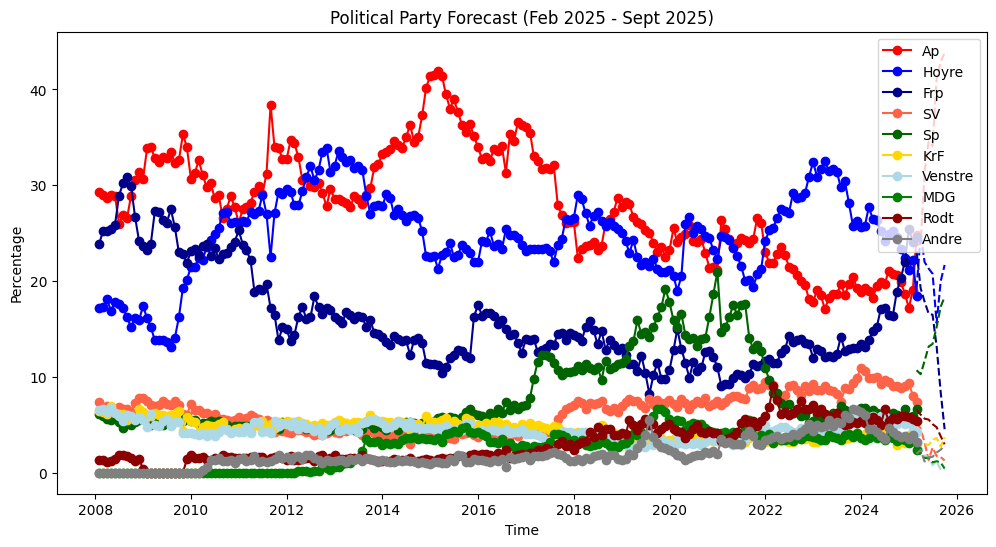

In [91]:
plt.figure(figsize=(12, 6))


# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}


plt.figure(figsize=(12, 6))

for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']:
    color = colors.get(party, np.random.rand(3,))  # Use predefined color or random if missing
    
    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast with the same color
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast (Feb 2025 - Sept 2025)")
plt.legend()
plt.show()

In [92]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,23.682842,19.233974,23.121339,5.169823,10.697152,2.249917,4.062564,2.586061,6.595484,1.977204
2025-03-31,23.931010,24.831444,19.236934,4.616388,10.278677,2.800985,2.765112,1.964055,6.061251,2.372493
2025-04-30,31.395748,21.985954,17.858775,3.136450,11.666404,2.968390,1.787708,1.527049,5.645985,1.171356
2025-05-31,34.550695,21.304558,16.606157,1.314895,13.167100,2.897177,1.615072,1.573781,5.543224,1.608492
2025-06-30,34.084513,20.776250,16.487143,2.625173,13.438650,3.423686,0.780878,1.079354,5.067726,1.659943
2025-07-31,41.103241,15.618814,13.174969,1.736286,15.196519,3.632332,1.220645,1.203667,4.747705,2.106027
2025-08-31,42.875618,19.991263,8.384917,1.625227,17.321523,2.721817,0.309115,1.068085,3.809296,2.405696
2025-09-30,43.832528,21.682642,4.540479,1.275823,18.354722,3.702284,0.326327,0.437113,2.966255,2.820066
